In [1]:
def plot_top_conversion_rates(df, category_col, target_col, top_n=10):
    
    # 각 범주별로 target_col의 True와 False의 개수를 집계
    conversion_counts = df.groupby([category_col, target_col]).size().unstack(fill_value=0)

    # True 비율
    conversion_rates = conversion_counts.div(conversion_counts.sum(axis=1), axis=0)

    # True 비율이 높은 상위 N개 범주를 선택
    top_categories = conversion_rates[True].sort_values(ascending=False).head(top_n).index

    top_conversion_rates = conversion_rates.loc[top_categories]

    ax = top_conversion_rates.plot(kind='bar', stacked=True, figsize=(10, 5))

    plt.title(f'Top {top_n}')
    plt.xlabel(category_col)
    plt.ylabel('Conversion Rate')
    plt.xticks(rotation=45)
    plt.legend(title=target_col, labels=['False', 'True'])

    # 그래프 표시
    plt.tight_layout()
    plt.show()


# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

In [2]:
!pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### 필수 라이브러리

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



from category_encoders import TargetEncoder


import seaborn as sns
import matplotlib.pyplot as plt

### 데이터 셋 읽어오기

In [4]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [5]:
df_train

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


## EDA

| Field                   | 설명                                                         |
| :---------------------- | :----------------------------------------------------------- |
| bant_submit             | MQL 구성 요소들 중 [1]Budget(예산), [2]Title(고객의 직책/직급), [3]Needs(요구사항), [4]Timeline(희망 납기일) 4가지 항목에 대해서 작성된 값의 비율 |
| customer_country        | 고객의 국적                                                  |
| business_unit           | MQL 요청 상품에 대응되는 사업부                              |
| com_reg_ver_win_rate    | Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산 |
| customer_idx            | 고객의 회사명                                                |
| customer_type           | 고객 유형                                                    |
| enterprise              | Global 기업인지, Small/Medium 규모의 기업인지                |
| historical_existing_cnt | 이전에 Converted(영업 전환) 되었던 횟수                      |
| id_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 ID일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| it_strategic_ver        | (도메인 지식) 특정 사업부(Business Unit이 IT일 때), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여 |
| idit_strategic_ver      | Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현 |
| customer_job            | 고객의 직업군                                                |
| lead_desc_length        | 고객이 작성한 Lead Descriptoin 텍스트 총 길이                |
| inquiry_type            | 고객의 문의 유형                                             |
| product_category        | 요청 제품 카테고리                                           |
| product_subcategory     | 요청 제품 하위 카테고리                                      |
| product_modelname       | 요청 제품 모델명                                             |
| customer_country.1      | 담당 자사 법인명 기반의 지역 정보(대륙)                      |
| customer_position       | 고객의 회사 직책                                             |
| response_corporate      | 담당 자사 법인명                                             |
| expected_timeline       | 고객의 요청한 처리 일정                                      |
| ver_cus                 | 특정 Vertical Level 1(사업영역) 이면서 Customer_type(고객 유형)이 소비자(End-user)인 경우에 대한 가중치 |
| ver_pro                 | 특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치 |
| ver_win_rate_x          | 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값 |
| ver_win_ratio_per_bu    | 특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산 |
| business_area           | 고객의 사업 영역                                             |
| business_subarea        | 고객의 세부 사업 영역                                        |
| lead_owner              | 영업 담당자 이름                                             |
| is_converted            | 영업 성공 여부. True일 시 성공.                              |

In [6]:
print(df_train['bant_submit'].value_counts())
print(df_test['bant_submit'].value_counts())

bant_submit
0.50    17192
1.00    17061
0.25    12852
0.75    11681
0.00      513
Name: count, dtype: int64
bant_submit
1.00    2070
0.25    1522
0.50     667
0.75     545
0.00     467
Name: count, dtype: int64


In [7]:
print(df_train['bant_submit'].isnull().sum())
print(df_test['bant_submit'].isnull().sum())

0
0


고유값 : 0.00, 0.25, 0.50, 0.75, 1.00
결측치 : x

# 1. customer_country

In [8]:
df_train['customer_country'].isnull().sum()

982

In [9]:
df_train['customer_country.1'].isnull().sum()

982

In [10]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity_score = similar(df_train['customer_country.1'].astype(str), df_train['customer_country'].astype(str))
print(f'유사도 확인 : {similarity_score:.2%}')


유사도 확인 : 100.00%


In [11]:
# customer_country.1과 유사도 판단 결과 100% 확인. 즉 customer_country.1 drop해야함.

In [12]:
df_train.drop('customer_country.1', axis=1, inplace=True)
df_test.drop('customer_country.1', axis=1, inplace=True)

In [13]:
import pandas as pd


def clean_customer_country(df):
    df_c = df['customer_country'].fillna('None')
    df_c = df_c.str.replace(pat='[ ]', repl='', regex=True).reset_index().drop('index', axis=1)

    
    c_list = df_c['customer_country'].str.split('/')
    result = [c[-1] for c in c_list]
    
  
    result_df = pd.DataFrame(result, columns=['customer_country'])

   
    replace_country = {
       'Manaus': 'Brazil',
    'Aparecida' : 'Brazil',
    'BR' : 'Brazil',
    'Dourados' : 'Brazil',
    'Cuiabá' : 'Brazil',
    'Recife' : 'Brazil',
    'SãoPaulo' : 'Brazil',
    'SaoPaulo' : 'Brazil',
    'JoãoPessoa' : 'Brazil',
    'Capãodacanoa' : 'Brazil',
    'BeloHorizonte' : 'Brazil',
    'SãoPaulo,Pinheiros' : 'Brazil',
    'CentrodeProduçãoAudiovisual-SescSãoPaulo' : 'Brazil',
    'FozdeIguaçu-PRAvenidaTancredoNeves6731JardimItaipu' : 'Brazil',
    'ViaE.DeAmicis,23.90044Carini(PA)' : 'Italy',
    'NewHampshire': 'UnitedStates',
    '1HoagDr.' : 'UnitedStates',
    '21903RanierLn' : 'UnitedStates',
    'JacksonvilleFlorida' : 'UnitedStates',
    'USVirginIslands' : 'UnitedStates',
    '3NassonAvenue' : 'UnitedStates',
    'Zip98433' : 'UnitedStates',
    'Nevada' : 'UnitedStates',
    'Ohio' : 'UnitedStates',
    'AnandViharDelhi' : 'India',
    'uttarpradesh' : 'India',
    'mumbai' : 'India',
    'Telangana' : 'India',
    'bangalore': 'India',
    'gujarat' : 'India',
    'gurgaon': 'India',
    'indore' : 'India',
    'kerela' : 'India',
    'Chennai' : 'India',
    'lucknow' : 'India',
    'Gujarat' : 'India',
    'Pune' : 'India',
    'odisha' : 'India',
    'hyderabad' : 'India',
    'bhilwara' : 'India',
    'CACERES' : 'Spain',
    'GRANCANARIASPLAYADELINGLES' : 'Spain',
    'VALENCIA' : 'Spain',
    'MADRID' : 'Spain',
    'SPAIN' : 'Spain',
    '1605Ave.PoncedeLeón,Suite400SanJuan,00909,PuertoRico' :'PuertoRico',
    'ΘέσηΠέτσαΒακαλοπούλουΒΙΟΠΑΠαλλήνης15351' : 'Greece',
    'Barranquilla' : 'Colombia',
    'Bucaramanga' : 'Colombia',
    'Cartagena' : 'Colombia',
    'COLOMBIA' : 'Colombia',
    'CARRERA11A94-46EDIFICIOCHICO3000PISO3BOGOTA' : 'Colombia',
    '1919MinnesotaCt,Mississauga,ONL5N' : 'Canada',
    'HaNoi' : 'Vietnam',
    'ARGENTINA' : 'Argentina',
    'EGYPT' : 'Egypt',
    'PerU' : 'Peru',
    'UAEDubai' : 'U.A.E',
    'Antigua' : 'AntiguaandBarbuda',
    'Dominicanrepublic' : 'DominicanRepublic',
    'NetherlandsAntilles' : 'Netherlands', 
    'A' : 'None',
    'country' : 'None',
    '':'None'
    }

    result_df['customer_country'] = result_df['customer_country'].replace(replace_country)

    result_df.loc[result_df['customer_country'].str.contains('UnitedStates'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains('Italy'), 'customer_country'] ='Italy'
    result_df.loc[result_df['customer_country'].str.contains('Colombia'), 'customer_country'] ='Colombia'
    result_df.loc[result_df['customer_country'].str.contains('ALICANTE'), 'customer_country'] ='Spain'

    result_df.loc[result_df['customer_country'].str.contains(r'^[A-Z]{2}$|[A-Z]{2}\d{5}$'), 'customer_country'] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\b[A-Z]{2}\d{5}\b|USA'), 'customer_country'] = 'UnitedStates'
    result_df['customer_country'][(result_df['customer_country'].str.contains(r'\d{5}'))
                             & (~result_df['customer_country'].str.contains('@'))] = 'UnitedStates'
    result_df.loc[result_df['customer_country'].str.contains(r'\d{4}$|^\d{4}|^\d{3}'), 'customer_country'] = 'UnitedStates'

    result_df['customer_country'][result_df['customer_country'].str.contains('@')] = 'None'
    return result_df


df_train['customer_country'] = clean_customer_country(df_train)
df_test['customer_country'] = clean_customer_country(df_test)


In [14]:
df_train['customer_country'].unique()

array(['Philippines', 'India', 'Nigeria', 'SaudiArabia', 'Singapore',
       'Brazil', 'U.A.E', 'SouthAfrica', 'UnitedStates', 'Colombia',
       'Mexico', 'Ghana', 'Egypt', 'DemocraticRepublicoftheCongo',
       'Ethiopia', 'Australia', 'None', 'Kenya', 'Indonesia', 'Oman',
       'Pakistan', 'UnitedKingdom', 'Guatemala', 'Panama', 'Canada',
       'Bangladesh', 'PapuaNewGuinea', 'UnitedRepublicofTanzania',
       'Qatar', 'Afghanistan', 'Chile', 'Mozambique', 'Turkey', 'Türkiye',
       'ElSalvador', 'Togo', 'Jordan', 'Iraq', 'Israel', 'SriLanka',
       'SouthKorea', 'Portugal', 'Mauritania', 'Uruguay', 'Peru',
       'Germany', 'Romania', 'Norway', 'Jamaica', 'Hungary', 'Poland',
       'Czech', 'Spain', 'Argentina', 'Ecuador', 'Senegal', 'HongKong',
       'Malaysia', 'Japan', 'Kuwait', 'Ireland', 'Albania', 'Greece',
       'Algeria', 'Nicaragua', 'Slovenia', 'Italy', 'Netherlands',
       'DominicanRepublic', 'France', 'Uganda', 'Iran', 'Paraguay',
       'Bolivia', 'Namibia', '

In [15]:
df_test['customer_country'].unique()

array(['Brazil', 'UnitedStates', 'U.A.E', 'Germany', 'Egypt', 'France',
       'None', 'UNITEDSTATES', 'Indonesia', 'India', 'Italy', 'Argentina',
       'Türkiye', 'SaudiArabia', 'Philippines', 'Peru', 'Vietnam',
       'Australia', 'Chile', 'Colombia', 'HongKong', 'Mexico', 'Thailand',
       'Serbia', 'BosniaandHerzegovina', 'Netherlands', 'Hungary',
       'Panama', 'UnitedKingdom', 'SouthAfrica', 'Maldives', 'Singapore',
       'Ecuador', 'Venezuela', 'Israel', 'Austria', 'Guatemala',
       'Belgium', 'Oman', 'Tunisia', 'Nicaragua', 'Somalia', 'China',
       'Canada', 'DemocraticRepublicoftheCongo', 'Poland',
       'DominicanRepublic', 'Spain', 'Greece', 'Qatar',
       'TrinidadandTobago', 'Kosovo', 'Algeria', 'Jordan', 'Bulgaria',
       'Cambodia', 'Romania', 'Georgia', 'ElSalvador', 'Jamaica',
       'Englewood,CO', 'Honduras', 'Switzerland', 'Cyprus', 'Bangladesh',
       'Kuwait', 'TurksandCaicosIslands', 'Portugal', 'Uruguay',
       'CostaRica', 'PuertoRico', 'Nigeria',

In [16]:
train_vals = set(df_train['customer_country'].unique())
test_vals = set(df_test['customer_country'].unique())

test_not_train = test_vals - train_vals

print(test_not_train)


{'W126N7449FlintDriveMenomoneeFallsVA', 'Englewood,CO', 'UNITEDSTATES', 'Liberia'}


In [17]:
# 'customer_country' 열에서 df_train에 없는 값을 'Other'로 대체
df_test['customer_country'] = df_test['customer_country'].apply(lambda x: 'Other' if x in test_not_train else x)


In [18]:
df_test['customer_country'].unique()

array(['Brazil', 'UnitedStates', 'U.A.E', 'Germany', 'Egypt', 'France',
       'None', 'Other', 'Indonesia', 'India', 'Italy', 'Argentina',
       'Türkiye', 'SaudiArabia', 'Philippines', 'Peru', 'Vietnam',
       'Australia', 'Chile', 'Colombia', 'HongKong', 'Mexico', 'Thailand',
       'Serbia', 'BosniaandHerzegovina', 'Netherlands', 'Hungary',
       'Panama', 'UnitedKingdom', 'SouthAfrica', 'Maldives', 'Singapore',
       'Ecuador', 'Venezuela', 'Israel', 'Austria', 'Guatemala',
       'Belgium', 'Oman', 'Tunisia', 'Nicaragua', 'Somalia', 'China',
       'Canada', 'DemocraticRepublicoftheCongo', 'Poland',
       'DominicanRepublic', 'Spain', 'Greece', 'Qatar',
       'TrinidadandTobago', 'Kosovo', 'Algeria', 'Jordan', 'Bulgaria',
       'Cambodia', 'Romania', 'Georgia', 'ElSalvador', 'Jamaica',
       'Honduras', 'Switzerland', 'Cyprus', 'Bangladesh', 'Kuwait',
       'TurksandCaicosIslands', 'Portugal', 'Uruguay', 'CostaRica',
       'PuertoRico', 'Nigeria', 'StMaarten', 'BurkinaF

In [19]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 172


In [20]:
# 빈도수가 낮은 국가에 대해서 처리 방안. ex) 5회 미만은 other로 분류 한다던가? 해야할듯!

In [21]:
from category_encoders import TargetEncoder

# 타겟 인코딩
target_encoder = TargetEncoder(smoothing=0.2)  # 스무딩 값을 조절하면서 객체 생성


df_train['customer_country'] = target_encoder.fit_transform(df_train['customer_country'], df_train['is_converted'])
df_test['customer_country'] = target_encoder.transform(df_test['customer_country'])


In [22]:
unique_values_count = df_train['customer_country'].nunique()
print("고유값 개수:", unique_values_count)


고유값 개수: 79


In [23]:
df_train['customer_country'].unique()

array([9.14752822e-02, 7.09627697e-02, 4.66666667e-01, 7.82312925e-02,
       1.15044248e-01, 6.40923112e-02, 1.33091349e-01, 8.95522388e-02,
       2.13993748e-01, 3.46038114e-02, 5.70286960e-02, 3.33333333e-01,
       2.53565769e-02, 8.17889003e-02, 8.17889003e-02, 1.26684636e-01,
       7.33070348e-02, 1.75438596e-02, 1.26865672e-01, 9.78260870e-02,
       3.44827586e-02, 1.57894737e-02, 1.03896104e-01, 9.49554896e-02,
       6.96864111e-02, 1.36986301e-02, 1.50684932e-01, 0.00000000e+00,
       7.09046455e-02, 8.17889003e-02, 4.18118467e-02, 2.29885057e-02,
       3.33333333e-02, 3.66492147e-02, 8.69565217e-02, 2.50194068e-08,
       4.08944502e-02, 1.68000000e-01, 8.69565202e-02, 3.87665198e-02,
       5.13392857e-02, 2.81250000e-01, 4.78477413e-02, 9.52380952e-02,
       6.95443645e-02, 2.28873239e-02, 1.74348697e-01, 2.12014134e-02,
       4.01534527e-01, 5.45454545e-02, 6.57894737e-02, 8.00000000e-02,
       1.59090909e-01, 3.03030303e-02, 6.95652174e-03, 1.17647059e-01,
      

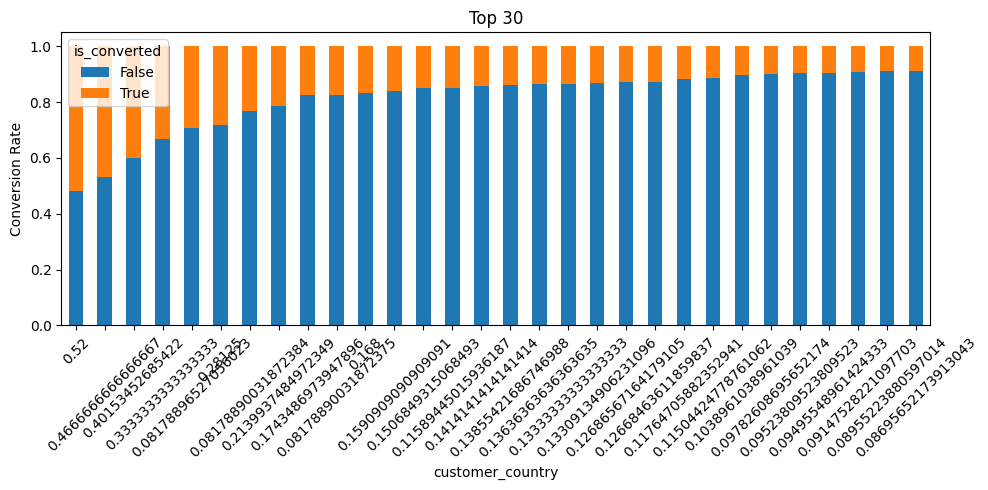

In [24]:
plot_top_conversion_rates(df_train, 'customer_country', 'is_converted', top_n=30)

# 2. business_unit

# 3. com_reg_ver_win_rate
- (Vertical Level 1, business unit, region을 기준으로 oppty 비율을 계산)

In [25]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

44731
3483


In [26]:
df_train['com_reg_ver_win_rate'].unique()

array([0.06666667, 0.08888889, 0.04081633, 0.00393701,        nan,
       0.05753425, 0.075     , 0.04464286, 0.08433735, 0.0199005 ,
       0.07494867, 0.04347826, 0.03119584, 0.14705882, 0.03305785,
       0.08069164, 0.33333333, 0.04310345, 0.11627907, 0.01351351,
       0.04854369, 0.01818182, 0.01185771, 0.21428571, 0.3902439 ,
       0.03225806, 0.01754386, 0.03278689, 0.05555556, 0.01515152,
       0.46153846, 0.06818182, 0.08333333, 0.26923077, 0.18181818,
       0.23076923, 0.64285714, 0.16666667, 0.01724138, 0.05389222,
       0.04968944, 0.01098901, 0.06779661, 0.03703704, 0.00378788,
       0.36363636, 0.10526316, 0.61538462, 0.08695652, 0.05442177,
       0.05319149, 0.07142857, 0.04      , 0.04166667, 0.02892562,
       0.11842105, 0.04918033, 0.11864407, 0.07324841, 0.02898551,
       0.01960784, 0.02272727, 0.004     , 0.125     , 0.01694915,
       0.12412178, 0.13636364, 0.02020202, 0.11363636, 0.03603604,
       0.06956522, 0.5       , 1.        , 0.25      , 0.44444

In [27]:
# 결측치 -> 0으로 대체

In [28]:
df_train['com_reg_ver_win_rate'] = df_train['com_reg_ver_win_rate'].fillna(0)
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(0)


In [29]:
print(df_train['com_reg_ver_win_rate'].isnull().sum())
print(df_test['com_reg_ver_win_rate'].isnull().sum())

0
0


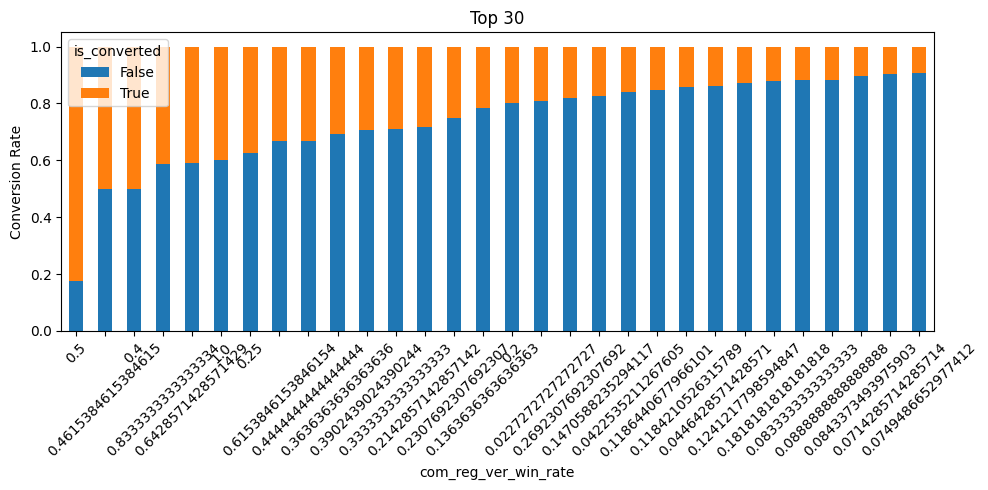

In [30]:
plot_top_conversion_rates(df_train, 'com_reg_ver_win_rate', 'is_converted', top_n=30)

# 4.customer_idx

In [31]:
df_train['customer_idx'].unique()

array([32160, 23122,  1755, ..., 19249, 40327, 30268])

In [32]:
print(df_train['customer_idx'].isnull().sum())
print(df_test['customer_idx'].isnull().sum())

0
0


In [33]:
df_train['customer_idx'].value_counts()

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64

In [34]:
# train에 없는 값이 test에 있을까? 

train_vals = set(df_train['customer_idx'].unique())
test_vals = set(df_test['customer_idx'].unique())

test_not_train = test_vals - train_vals

print(test_not_train) 

{16384, 1, 4, 8200, 9, 32776, 32779, 24588, 24589, 40973, 8208, 24592, 40976, 32787, 22, 40983, 8219, 30, 36, 8231, 24619, 43, 32813, 32814, 16431, 48, 24620, 8242, 41007, 54, 24632, 8249, 16452, 69, 24644, 8266, 8271, 41043, 16467, 24661, 32857, 16477, 24672, 32866, 24675, 32868, 104, 107, 41070, 16495, 41071, 113, 16497, 24691, 8305, 24687, 32888, 32892, 130, 41094, 136, 16521, 24714, 41098, 24717, 41103, 41108, 24727, 32924, 156, 163, 32931, 166, 167, 41137, 16562, 8372, 24758, 183, 41143, 32952, 8379, 41155, 32964, 16580, 32965, 32968, 32969, 24777, 16587, 204, 203, 205, 41166, 24778, 8401, 24780, 8406, 214, 24795, 41180, 8414, 16609, 16610, 8418, 32996, 8417, 33003, 24814, 16623, 16627, 41214, 24831, 256, 16641, 16645, 33033, 16651, 24844, 33037, 24846, 24848, 41235, 8474, 8475, 33050, 33052, 24862, 8479, 8480, 41247, 16681, 16683, 33072, 41265, 33078, 41273, 41274, 315, 24895, 16705, 8514, 33093, 24902, 24903, 24904, 41289, 8522, 24909, 33102, 8526, 33105, 33106, 33107, 33108, 24

In [35]:
# 너무많네...

In [36]:
# 딱히 관련 있는 칼럼도 없고..

In [37]:

top_values = df_train['customer_idx'].value_counts().tail(500)
print(top_values)


customer_idx
46688    1
43427    1
23508    1
3812     1
36774    1
        ..
39487    1
41241    1
39422    1
22515    1
30268    1
Name: count, Length: 500, dtype: int64


In [38]:
print((df_train['customer_idx'] == 0).any())


False


In [39]:
count_1 = (df_train['customer_idx'].value_counts() == 1).sum()
print(f"빈도수가 1인 행의 개수: {count_1}")


빈도수가 1인 행의 개수: 27331


In [40]:
# customer_idx 값별 빈도수 계산
idx_counts_train = df_train['customer_idx'].value_counts()
idx_counts_test = df_test['customer_idx'].value_counts()

# 빈도수가 1인 값들을 0으로 대체
df_train['customer_idx'] = df_train['customer_idx'].apply(lambda x: 0 if idx_counts_train[x] == 1 else x)
df_test['customer_idx'] = df_test['customer_idx'].apply(lambda x: 0 if idx_counts_test[x] == 1 else x)


In [41]:
# 'customer_idx' 열의 데이터 타입 확인
print(df_train['customer_idx'].dtype)

# 'customer_idx' 열을 범주형으로 변환 (만약 int64일 경우)!!!!?
df_train['customer_idx'] = df_train['customer_idx'].astype(str)
df_test['customer_idx'] = df_test['customer_idx'].astype(str)

# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.3)
df_train['customer_idx'] = target_encoder.fit_transform(df_train['customer_idx'], df_train['is_converted'])
df_test['customer_idx'] = target_encoder.transform(df_test['customer_idx'])  # 'transform'만 호출하여 새로운 데이터에 적용


int64


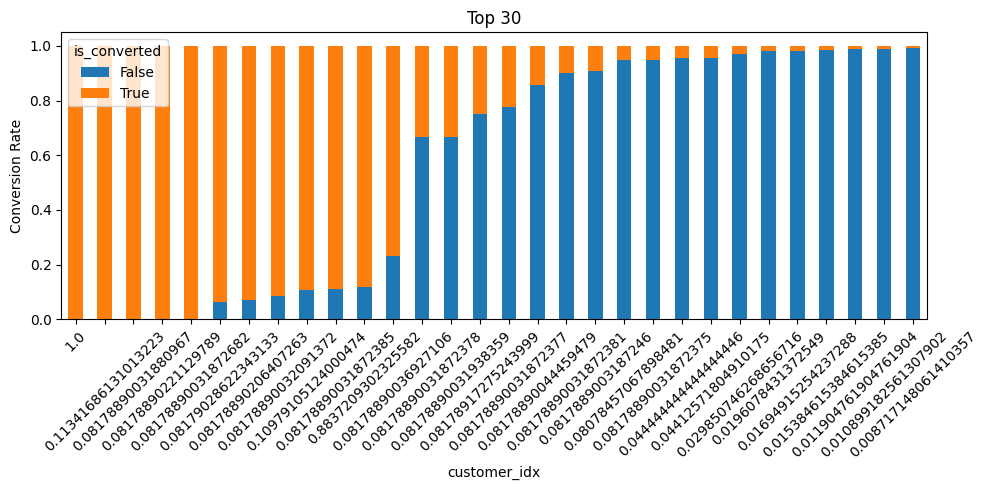

In [42]:
plot_top_conversion_rates(df_train, 'customer_idx', 'is_converted', top_n=30)

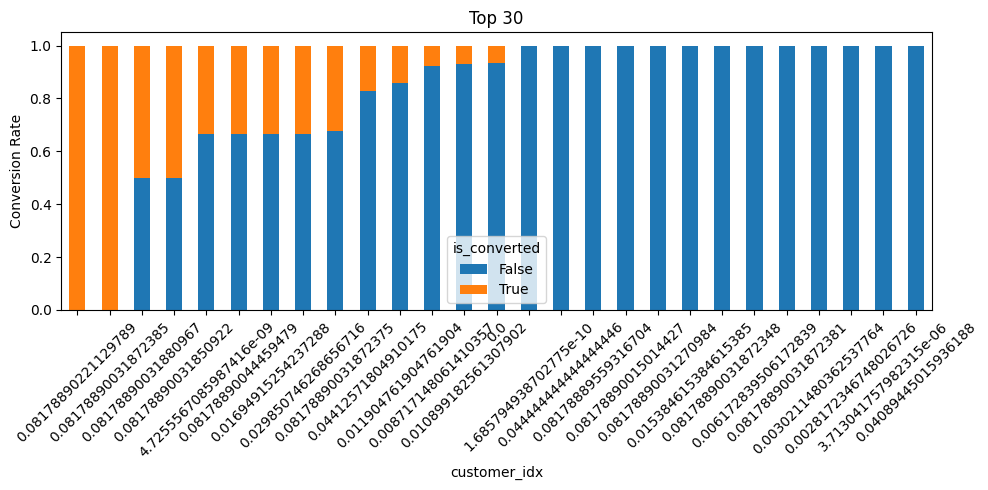

In [43]:
plot_top_conversion_rates(df_test, 'customer_idx', 'is_converted', top_n=30)

# 그외 범주형 전처리

# expected_timeline

In [44]:
import pandas as pd

def update_expected_timeline(value):
    if pd.notna(value):
        original_value = value
        mapping_rules = {
            ('requi', 'reqi'): 'requirement',
            ('no', 'not'): 'no requirement',
            ('follow',): 'follow',
            ('details',): 'details shared',
            ('call back', 'call later', 'call after'): 'call back'
        }
        for keywords, updated_value in mapping_rules.items():
            if any(keyword in value for keyword in keywords):
                return updated_value
        return original_value

def classify_other(df):
    value_counts = df['expected_timeline'].value_counts()
    single_occurrence_values = value_counts[value_counts == 1].index
    df['expected_timeline'] = df['expected_timeline'].apply(lambda x: 'Other' if x in single_occurrence_values else x)
    return df

def mapping(df, timeline_mapping):
    df['expected_timeline'] = df['expected_timeline'].apply(update_expected_timeline)
    df['expected_timeline'] = df['expected_timeline'].map(timeline_mapping).fillna(df['expected_timeline'])
    return df

timeline_mapping = {
    "less than 3 months": "0-3m",
    "less_than_3_months": "0-3m",
    "3 months ~ 6 months": "3-6m",
    "3_months_~6_months": "3-6m",
    "6 months ~ 9 months": "6-9m",
    "6_months~9_months": "6-9m",
    "9 months ~ 1 year": "9-12m",
    "9_months~_1_year": "9-12m",
    "up to december": "1y",
    "more than a year": "1y",
    "more_than_a_year": "1y",
    "couldn't connect": "no response",
    "didn't respond": "no response",
    "rnr": "no response",
    "reponse": "response"
}

# 데이터프레임 불러오기 (가정)
# df_train = pd.read_csv('your_train_data.csv')
# df_test = pd.read_csv('your_test_data.csv')

df_train = mapping(df_train, timeline_mapping)
df_test = mapping(df_test, timeline_mapping)
df_train = classify_other(df_train)
df_test = classify_other(df_test)

# nan을 'no requirement'로 채우기
df_train['expected_timeline'].fillna('no requirement', inplace=True)
df_test['expected_timeline'].fillna('no requirement', inplace=True)


In [45]:
# TargetEncoder 적용
target_encoder = TargetEncoder(smoothing=0.2)
df_train['expected_timeline'] = target_encoder.fit_transform(df_train['expected_timeline'], df_train['is_converted'])
df_test['expected_timeline'] = target_encoder.transform(df_test['expected_timeline'])  # 'transform'만 호출하여 새로운 데이터에 적용


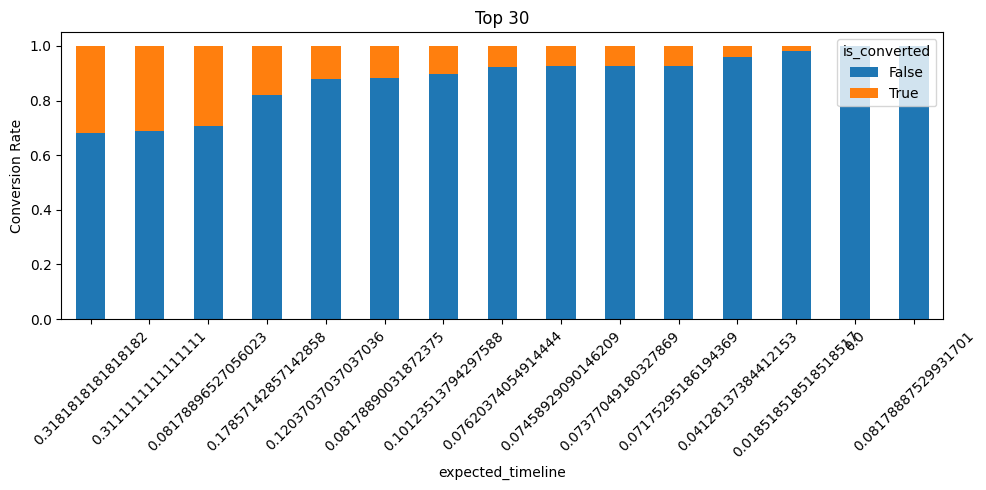

In [46]:
plot_top_conversion_rates(df_train, 'expected_timeline', 'is_converted', top_n=30)

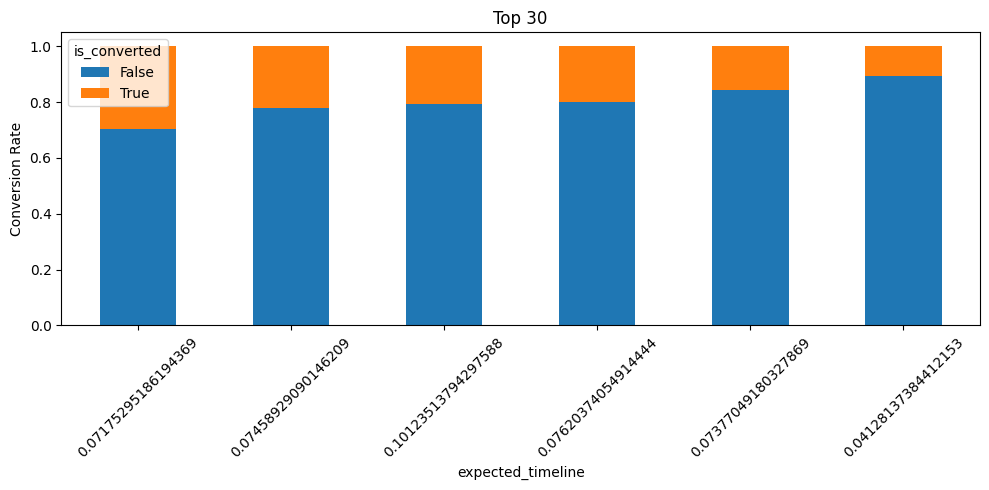

In [47]:
plot_top_conversion_rates(df_test, 'expected_timeline', 'is_converted', top_n=30)

# business_subarea

In [48]:
# df_train
grouped_data_train = df_train.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_train = df_train.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['business_subarea'] = df_train.apply(lambda row: mode_subarea_by_area_train.get(row['business_area'], row['business_subarea']), axis=1)

# df_test
grouped_data_test = df_test.groupby('business_area')['business_subarea'].apply(list)
mode_subarea_by_area_test = df_test.groupby('business_area')['business_subarea'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['business_subarea'] = df_test.apply(lambda row: mode_subarea_by_area_test.get(row['business_area'], row['business_subarea']), axis=1)

### 레이블 인코딩

In [49]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [50]:
# 레이블 인코딩할 칼럼들
label_columns = [
    #"customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    #"customer_country.1",
    "customer_position",
    "response_corporate",
    #"expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

In [51]:
df_all

,business_subarea,business_area,business_unit,customer_type,enterprise,customer_job,inquiry_type,product_category,product_subcategory,product_modelname,customer_position,response_corporate
0,7,0,0,10,0,420,32,180,349,699,47,33
1,7,0,0,10,0,303,32,180,349,699,21,33
2,7,0,0,10,0,160,27,238,349,699,80,21
3,7,0,0,10,0,166,32,318,349,699,21,21
4,7,0,0,29,0,84,32,180,349,699,80,21
...,...,...,...,...,...,...,...,...,...,...,...,...
5266,11,6,0,33,0,468,30,183,349,699,9,43
5267,11,6,3,33,0,323,30,183,349,699,74,50
5268,11,6,0,29,0,166,58,180,349,699,64,43
5269,11,6,3,9,1,323,58,52,349,699,74,12


다시 학습 데이터와 제출 데이터를 분리합니다.

In [52]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [53]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=684050,
)





## 3. 모델 학습

### 모델 정의 

In [54]:
model = DecisionTreeClassifier()

### 모델 학습

In [55]:
model.fit(x_train.fillna(0), y_train)

DecisionTreeClassifier()

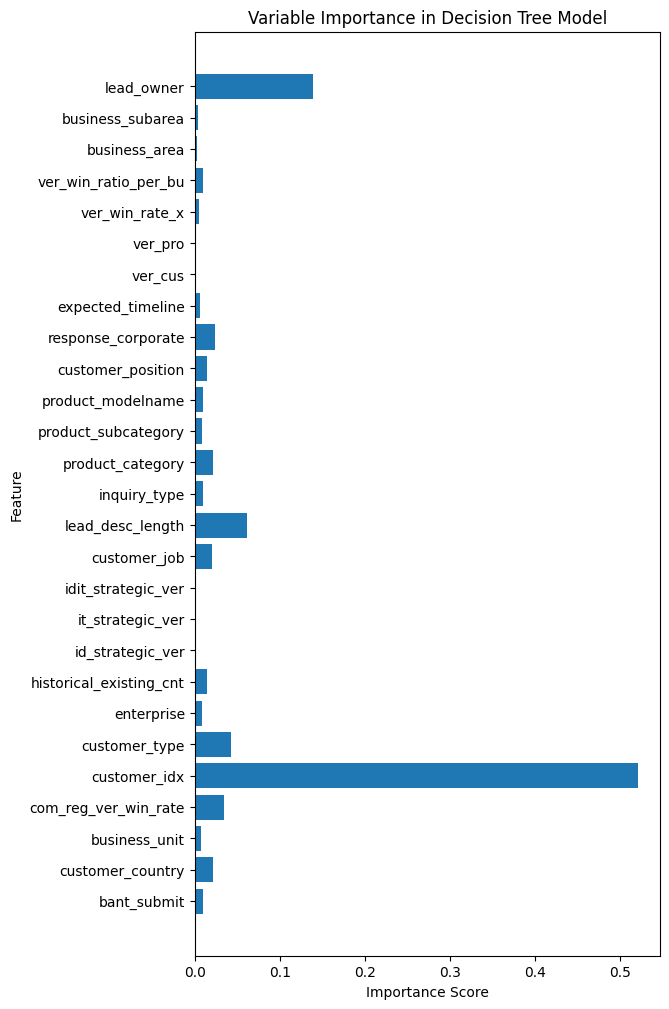

In [66]:
# 변수 중요도 확인
feature_importances = model.feature_importances_

plt.figure(figsize=(6, 12))
plt.barh(range(x_train.shape[1]), feature_importances, align='center')
plt.yticks(range(x_train.shape[1]), x_train.columns)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Variable Importance in Decision Tree Model')
plt.show()

### 모델 성능 보기

In [57]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [58]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[  806   181]
 [  227 10646]]

정확도: 0.9656
정밀도: 0.7803
재현율: 0.8166
F1: 0.7980


## 4. 제출하기

### 테스트 데이터 예측

In [59]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [60]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

871

### 제출 파일 작성

In [61]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**